# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False)
dfc_g = dfc_g.transpose()  
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail())
display('chg in cases',dfc_g.tail().diff(axis=0))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False)
dfd_g = dfd_g.transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail())
display('chg in deaths',dfd_g.tail().diff(axis=0))

#display('details of', dfd_g['Sudan'].tail(15), dfc_g['Sudan'].tail(15))


'cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,China,Iran,Turkey,Belgium,...,MS Zaandam,Holy See,Papua New Guinea,Mauritania,Western Sahara,Burundi,Bhutan,Sao Tome and Principe,South Sudan,Yemen
2020-04-12,555313,166831,156363,121712,127854,85206,83134,71686,56956,29647,...,9,8,2,7,6,5,5,4,4,1
2020-04-13,580619,170099,159516,125394,130072,89570,83213,73303,61049,30589,...,9,8,2,7,6,5,5,4,4,1
2020-04-14,607670,172541,162488,131361,131359,94845,83306,74877,65111,31119,...,9,8,2,7,6,5,5,4,4,1
2020-04-15,636350,177644,165155,134582,134753,99483,83356,76389,69392,33573,...,9,8,2,7,6,5,5,4,4,1
2020-04-16,667801,184948,168941,147091,137698,104145,83403,77995,74193,34809,...,9,8,7,7,6,5,5,4,4,1


'chg in cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,China,Iran,Turkey,Belgium,...,MS Zaandam,Holy See,Papua New Guinea,Mauritania,Western Sahara,Burundi,Bhutan,Sao Tome and Principe,South Sudan,Yemen
2020-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,25306.0,3268.0,3153.0,3682.0,2218.0,4364.0,79.0,1617.0,4093.0,942.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-14,27051.0,2442.0,2972.0,5967.0,1287.0,5275.0,93.0,1574.0,4062.0,530.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-15,28680.0,5103.0,2667.0,3221.0,3394.0,4638.0,50.0,1512.0,4281.0,2454.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-16,31451.0,7304.0,3786.0,12509.0,2945.0,4662.0,47.0,1606.0,4801.0,1236.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Iran,Belgium,Germany,China,Netherlands,...,Fiji,Saint Vincent and the Grenadines,Chad,Saint Lucia,Eritrea,Equatorial Guinea,Saint Kitts and Nevis,Dominica,Rwanda,Central African Republic
2020-04-12,22019,19899,17209,14412,10629,4474,3600,3022,3343,2747,...,0,0,0,0,0,0,0,0,0,0
2020-04-13,23528,20465,17756,14986,11347,4585,3903,3194,3345,2833,...,0,0,0,0,0,0,0,0,0,0
2020-04-14,25831,21067,18056,15748,12129,4683,4157,3294,3345,2955,...,0,0,0,0,0,0,0,0,0,0
2020-04-15,28325,21645,18708,17188,12894,4777,4440,3804,3346,3145,...,0,0,0,0,0,0,0,0,0,0
2020-04-16,32916,22170,19315,17941,13759,4869,4857,4052,3346,3327,...,0,0,0,0,0,0,0,0,0,0


'chg in deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Iran,Belgium,Germany,China,Netherlands,...,Fiji,Saint Vincent and the Grenadines,Chad,Saint Lucia,Eritrea,Equatorial Guinea,Saint Kitts and Nevis,Dominica,Rwanda,Central African Republic
2020-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,1509.0,566.0,547.0,574.0,718.0,111.0,303.0,172.0,2.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-14,2303.0,602.0,300.0,762.0,782.0,98.0,254.0,100.0,0.0,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-15,2494.0,578.0,652.0,1440.0,765.0,94.0,283.0,510.0,1.0,190.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-16,4591.0,525.0,607.0,753.0,865.0,92.0,417.0,248.0,0.0,182.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Global Population Comparisons

In [73]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})

display(df_gpop_2016.sort_values(by=['Value'], ascending=False).head(), dfc_g.tail(1).transpose().count())  #262 countries / n countries
df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

display(df_gmerged.rename(columns={'US':'United States'}).sort_values(by=['Population'], ascending=False).head())

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })
       
display(df_gmerged.sort_values(by=['Population'], ascending=False).head(), df_gmerged.tail(1).transpose().count())



,Country/Region,Country Code,Year,Value
2711,World,WLD,2016,7426103221
1000,IDA & IBRD total,IBT,2016,6256138021
1531,Low & middle income,LMY,2016,6227752871
1885,Middle income,MIC,2016,5557635482
941,IBRD only,IBD,2016,4687686335


2020-04-16    185
dtype: int64

,Country/Region,Cases,Country Code,Year,Population
6,China,83403,CHN,2016,1378665000
15,India,13430,IND,2016,1324509589
0,United States,667801,USA,2016,322941311
33,Indonesia,5516,IDN,2016,261554226
10,Brazil,30425,BRA,2016,206163058


,Country/Region,Deaths,Cases,Country Code,Year,Population
7,China,3346,83403,CHN,2016,1378665000
18,India,448,13430,IND,2016,1324509589
0,United States,32916,667801,USA,2016,322941311
15,Indonesia,496,5516,IDN,2016,261554226
9,Brazil,1924,30425,BRA,2016,206163058


158    6
dtype: int64

## Add Population Density from worldbank

In [74]:
# population density source
# http://api.worldbank.org/v2/en/indicator/EN.POP.DNST?downloadformat=csv   
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def get_zip(url):
    urllib.request.urlretrieve(url, "GDP.zip")
    compressed_file = zipfile.ZipFile('GDP.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code') 
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm


## Add demographics from worldbank

In [198]:
#  -- all available https://data.worldbank.org/indicator
#  API docs https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures
#
#   Examples:
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop% http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv
# pollution EN.ATM.PM25.MC.M3
# slum% indicator/ EN.POP.SLUM.UR.ZS

df_gmerged3 = df_gmerged.copy()  # df_gmerged2 no longer needed

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.POP.SLUM.UR.ZS', 'slum%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.POP.DNST', 'popdensity%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('NY.GDP.PCAP.PP.CD', 'GDP/cap', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SE.ADT.LITR.ZS', 'literacy', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('FR.INR.DPST', 'deposit rate', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.DTH.COMM.ZS', 'COD disease', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.IMM.IDPT', 'DTP immunized', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.POP.65UP.TO.ZS', 'pop% >= 65', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('TG.VAL.TOTL.GD.ZS', 'trade%', df_gmerged3, year='2019', debug=False)


df_gmerged3 = df_gmerged3.sort_values(by='Cases', ascending=False).drop(columns=['Year'])

df_x = pd.concat([df_gmerged3.head(0), df_gmerged3[df_gmerged3['Country/Region'].isin(['Japan','Brazil','India'])]], axis=0)

display(df_gmerged3.shape, df_x[['Country/Region','Cases','flights','railways','hospbeds','popdensity%','pop% >= 65','pollution','GDP/cap','COD disease','urbanpop%','unemp%']].transpose())


(159, 20)

,Country/Region,Cases,flights,railways,hospbeds,popdensity%,pop% >= 65,pollution,GDP/cap,COD disease,urbanpop%,unemp%
9,Brazil,30425,832683.00,32622.0,2.2,25.06,8.92,12.71,16096.40,13.9,86.57,12.08
18,India,13430,1200111.36,68443.0,0.7,454.94,6.18,90.87,7762.88,26.0,34.03,5.36
28,Japan,8626,999594.00,16851.7,13.4,347.07,27.58,11.70,42797.46,12.7,91.62,2.29


In [199]:
display(df_gmerged3.shape, df_x[['Country/Region','Cases','flights','railways','hospbeds','popdensity%','pop% >= 65','pollution','GDP/cap','COD disease','urbanpop%','unemp%']].transpose())


(159, 20)

,9,18,28
Country/Region,Brazil,India,Japan
Cases,30425,13430,8626
flights,832683,1.20011e+06,999594
railways,32622,68443,16851.7
hospbeds,2.2,0.7,13.4
popdensity%,25.06,454.94,347.07
pop% >= 65,8.92,6.18,27.58
pollution,12.71,90.87,11.7
GDP/cap,16096.4,7762.88,42797.5
COD disease,13.9,26,12.7


In [76]:
# df_gmerged4 ready to go
df_gmerged4 = df_gmerged3.copy()
df_gmerged4[df_gmerged4['Country/Region'].isin(['Belarus','Poland','Spain','France','Sweden','India','Korea, South','Japan','United States','South Africa'])].transpose()


,0,2,3,18,11,28,25,54,50
Country/Region,United States,Spain,France,India,Sweden,Japan,Poland,Belarus,South Africa
Deaths,32916,19315,17941,448,1333,178,314,40,48
Cases,667801,184948,147091,13430,12540,8626,7918,4204,2605
Country Code,USA,ESP,FRA,IND,SWE,JPN,POL,BLR,ZAF
Population,322941311,46484062,66721256,1324509589,9923085,126994511,37970087,9501534,56203654
flights,9.87963e+06,641020,597412,1.20011e+06,190315,999594,123903,31676,180317
pollution,7.41,9.7,11.81,90.87,6.18,11.7,20.88,18.77,25.1
unemp%,3.68,13.96,8.43,5.36,6.48,2.29,3.47,4.59,28.18
hospbeds,2.9,3,6.5,0.7,2.6,13.4,6.5,11,2.8
railways,150462,15618,28241,68443,9708,16851.7,18536,5459,20953


# Correlation Matrix

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Deaths,1.000000,0.903648,0.164206,0.671890,-0.159426,0.027217,0.090008,0.662163,0.180630,-0.181630,-0.025627,0.248461,-0.192909,-0.120976,-0.162095,0.091469,0.317097,-0.073405
Cases,0.903648,1.000000,0.229261,0.873542,-0.131218,-0.010429,0.085331,0.821645,0.166588,-0.164552,-0.025279,0.249347,-0.204643,-0.092794,-0.153924,0.085385,0.258520,-0.089705
Population,0.164206,0.229261,1.000000,0.503798,0.267416,-0.049807,-0.036975,0.612453,-0.060774,0.009955,-0.017312,-0.042647,0.024591,-0.026367,-0.018070,0.029798,0.010736,-0.141224
flights,0.671890,0.873542,0.503798,1.000000,-0.055782,-0.070206,0.057644,0.910928,0.141160,-0.138750,-0.024821,0.222829,-0.182516,-0.089135,-0.146960,0.089789,0.181807,-0.101634
pollution,-0.159426,-0.131218,0.267416,-0.055782,1.000000,0.034698,-0.385119,-0.033383,-0.230348,0.477390,-0.100991,-0.172031,0.132855,0.111566,0.416183,-0.111487,-0.466812,-0.100274
unemp%,0.027217,-0.010429,-0.049807,-0.070206,0.034698,1.000000,-0.002011,-0.011623,0.120080,0.026280,-0.125099,-0.148474,0.237484,0.130979,0.009034,-0.098822,0.062347,-0.019466
hospbeds,0.090008,0.085331,-0.036975,0.057644,-0.385119,-0.002011,1.000000,0.138858,0.388271,-0.565877,0.332303,0.305930,-0.010130,-0.163978,-0.513351,0.295807,0.601188,0.223852
railways,0.662163,0.821645,0.612453,0.910928,-0.033383,-0.011623,0.138858,1.000000,0.142949,-0.172386,-0.042580,0.182165,-0.167972,-0.069401,-0.162519,0.078569,0.251617,-0.128805
urbanpop%,0.180630,0.166588,-0.060774,0.141160,-0.230348,0.120080,0.388271,0.142949,1.000000,-0.478795,0.181979,0.606855,-0.022595,-0.110195,-0.532877,0.334991,0.408456,0.181994
slum%,-0.181630,-0.164552,0.009955,-0.138750,0.477390,0.026280,-0.565877,-0.172386,-0.478795,1.000000,-0.113728,-0.551982,-0.078594,0.289491,0.799900,-0.276597,-0.605509,-0.244386


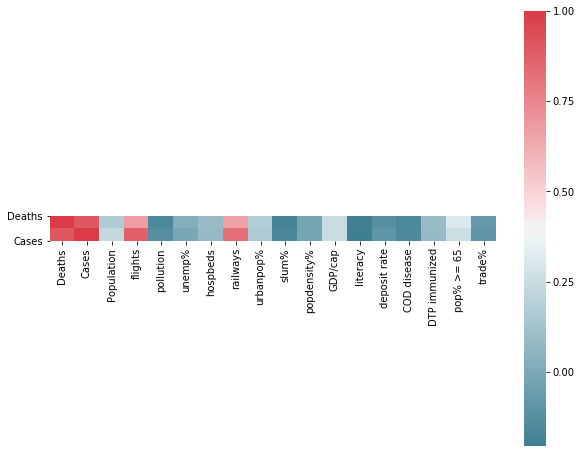

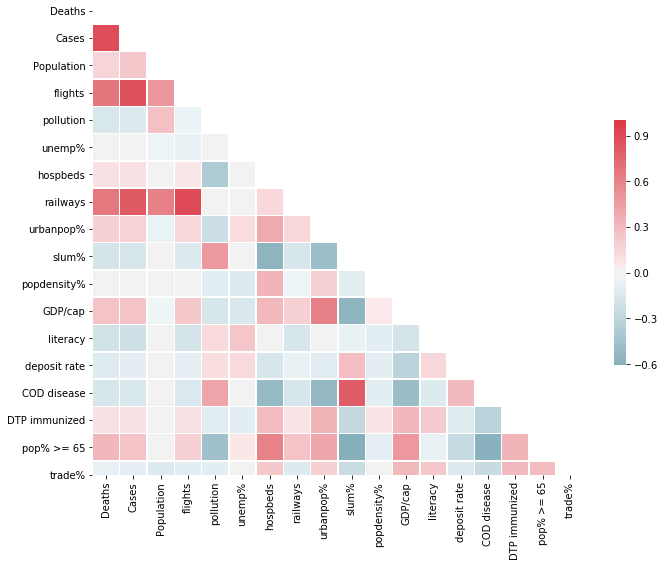

In [77]:
import seaborn as sns

df_corr = df_gmerged4.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_corr


## Scaling / Normalization

In [78]:
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
scaler = StandardScaler()

df_sc = df_gmerged4.copy().set_index('Country/Region').drop(columns=['Country Code'])
display('orig',df_sc.head(2))

df_sc = pd.DataFrame(scaler.fit_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
display('scale',df_sc.head(2))

# df_sc = pd.DataFrame(scaler.inverse_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
# display('inverse',df_sc.head(2))

'orig'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
United States,32916,667801,322941311,9879630.0,7.41,3.68,2.9,150462.3,82.26,0.0,35.77,62794.59,0.00,0.0,5.2,94.0,15.81,20.83
Spain,19315,184948,46484062,641020.0,9.70,13.96,3.0,15618.0,80.32,0.0,93.53,39715.44,98.44,0.0,5.1,93.0,19.38,51.67


'scale'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
United States,8.221962,11.098789,1.809402,10.876939,-1.012400,-0.533644,0.018517,9.518885,0.955201,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Spain,4.732600,2.917920,0.026889,0.472386,-0.894881,1.370712,0.060101,0.686980,0.871687,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125


# Misc Clustering Techniques

In [79]:
# kmeans apply to a subset of my data

df_gm5 = df_sc.copy()
df_train = pd.concat([df_gm5.iloc[0:10,6:10],df_gm5.loc[['Japan','Pakistan','France','Italy']].iloc[:,6:10]], axis=0)
df_test = df_gm5.iloc[20:22,6:10]

display('train',df_train)
display('test',df_test)

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'inertia: {kmeans.inertia_} iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels
display(kmeans.cluster_centers_)                           # k-centers
display(f'kmeans.predict x2: {kmeans.predict(df_test)}')  # evaluate 2 arb points
display(f'score {kmeans.score(df_test)}') # score
display(f'transform: {kmeans.transform(df_test)}')  # what does this do, distance of each pt ?

df_train['cluster'] = kmeans.labels_
df_test['cluster'] = kmeans.predict(df_test)
display('train',df_train)
display('test',df_test)

'train'

,hospbeds,railways,urbanpop%,slum%
Country/Region,,,,
United States,0.018517,9.518885,0.955201,-0.882278
Spain,0.060101,0.686980,0.871687,-0.882278
Italy,0.226437,0.763632,0.446370,-0.882278
France,1.515545,1.513750,0.876853,-0.882278
Germany,2.264060,1.854269,0.742112,-0.882278
United Kingdom,-0.023067,0.709446,1.004276,-0.882278
China,0.559110,4.086081,-0.039645,0.007618
Turkey,-0.064652,0.339650,0.648697,-0.462049
Belgium,1.390793,-0.099836,1.632781,-0.882278


'test'

,hospbeds,railways,urbanpop%,slum%
Country/Region,,,,
Chile,-0.272572,-0.197099,1.183357,-0.564458
Japan,4.384850,0.767784,1.358133,-0.882278


'inertia: 29.76007997253885 iters: 2'

'labels: [1 0 0 2 2 0 0 0 2 0 2 0 2 0]'

array([[-2.27535807e-03,  1.28889838e+00,  4.11124453e-01,
        -5.17667889e-01],
       [ 1.85167070e-02,  9.51888537e+00,  9.55201141e-01,
        -8.82278029e-01],
       [ 2.21415878e+00,  1.10994338e+00,  1.09734662e+00,
        -8.82278029e-01]])

'kmeans.predict x2: [0 2]'

'score -7.776765452089066'

'transform: [[1.69699171 9.72821399 2.8285328 ]\n [4.53301207 9.78820703 2.21291315]]'

'train'

,hospbeds,railways,urbanpop%,slum%,cluster
Country/Region,,,,,
United States,0.018517,9.518885,0.955201,-0.882278,1
Spain,0.060101,0.686980,0.871687,-0.882278,0
Italy,0.226437,0.763632,0.446370,-0.882278,0
France,1.515545,1.513750,0.876853,-0.882278,2
Germany,2.264060,1.854269,0.742112,-0.882278,2
United Kingdom,-0.023067,0.709446,1.004276,-0.882278,0
China,0.559110,4.086081,-0.039645,0.007618,0
Turkey,-0.064652,0.339650,0.648697,-0.462049,0
Belgium,1.390793,-0.099836,1.632781,-0.882278,2


'test'

,hospbeds,railways,urbanpop%,slum%,cluster
Country/Region,,,,,
Chile,-0.272572,-0.197099,1.183357,-0.564458,0
Japan,4.384850,0.767784,1.358133,-0.882278,2


In [88]:
## apply to all cols
from sklearn.model_selection import train_test_split
df_gm5 = df_sc.copy()
df_train,df_test = train_test_split(df_gm5,test_size=0.2)

display('train',df_train.shape, df_train.head(3))
display('test',df_test.shape, df_test.head(3))

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'inertia: {kmeans.inertia_} iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels
display(kmeans.cluster_centers_)                           # k-centers
display(f'kmeans.predict x2: {kmeans.predict(df_test)}')  # evaluate 2 arb points
display(f'score {kmeans.score(df_test)}') # score
display(f'transform: {kmeans.transform(df_test)}')  # what does this do, distance of each pt ?

def fl_col(df):
    return pd.concat([df.iloc[:,0:3],df.iloc[:,-2:]], axis=1)
    
df_train['cluster'] = kmeans.labels_
df_test['cluster'] = kmeans.predict(df_test)
display('train',fl_col(df_train).head(10))
display('test',fl_col(df_test).head(3))


'train'

(127, 18)

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
Slovenia,-0.207050,-0.194129,-0.259512,-0.228762,-0.570548,-0.437315,0.725447,-0.256767,-0.238098,-0.882278,-0.142807,0.726936,0.834331,-0.814337,-0.782378,0.350364,1.649051,2.741391
Sierra Leone,-0.222700,-0.215358,-0.225572,-0.247118,-0.282652,-0.394708,-1.021087,-0.335953,-0.775340,1.787410,-0.140771,-0.874612,-0.753168,0.109123,1.754402,0.183073,-0.869039,-0.168178
Kenya,-0.219878,-0.211648,0.043444,-0.094565,0.074012,-0.726303,-0.605245,-0.210395,-1.422356,1.095268,-0.150307,-0.792634,0.323712,1.066618,2.013355,0.294600,-0.964375,-0.962857


'test'

(32, 18)

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
Romania,-0.122132,-0.085034,-0.145791,-0.186875,-0.642907,-0.478070,1.432377,0.369123,-0.261344,-0.882278,-0.153747,0.294440,0.810163,-0.519374,-0.820742,-0.039981,1.456865,0.355412
Libya,-0.222443,-0.214782,-0.230967,-0.241185,1.391356,2.222855,0.351190,-0.335953,0.862217,0.360751,-0.202882,-0.032585,0.452140,-0.247101,-0.638516,0.573418,-0.654154,0.236099
South Sudan,-0.222700,-0.215545,-0.202982,-0.249533,0.946425,1.052084,-1.187423,-0.335953,-1.741775,2.493676,-0.205192,-0.860609,-0.997378,-0.773496,2.018151,-2.103236,-0.803968,-1.699822


'inertia: 1630.6267289442712 iters: 6'

'labels: [2 0 0 2 2 2 0 0 2 2 0 2 2 1 0 0 2 2 0 2 0 0 2 2 0 2 2 0 2 0 2 2 2 2 2 0 2\n 2 2 0 0 2 0 0 0 2 2 2 2 0 0 2 2 2 0 2 2 2 2 2 0 0 2 0 0 2 0 0 2 2 2 0 0 0\n 2 0 2 2 2 2 0 2 2 0 2 2 2 0 2 0 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 0 2 0\n 2 0 0 2 2 2 0 2 0 2 0 0 0 0 0 0]'

array([[-2.13750817e-01, -2.01097377e-01,  8.26989504e-02,
        -1.74969840e-01,  3.71638480e-01, -3.57886932e-03,
        -6.64604553e-01, -1.60912398e-01, -7.72909512e-01,
         9.19878953e-01, -1.14228595e-01, -7.10295671e-01,
        -1.45998731e-01,  3.04653078e-01,  9.84501302e-01,
        -6.56661634e-01, -7.75275043e-01, -4.03952357e-01],
       [ 8.22196213e+00,  1.10987888e+01,  1.80940168e+00,
         1.08769391e+01, -1.01240022e+00, -5.33644231e-01,
         1.85167070e-02,  9.51888537e+00,  9.55201141e-01,
        -8.82278029e-01, -1.83450514e-01,  1.81431816e+00,
        -1.96746930e+00, -8.14337189e-01, -7.72787555e-01,
         4.06127582e-01,  1.07400666e+00, -1.12184793e+00],
       [ 1.15565429e-01,  5.48331704e-02, -2.91775299e-02,
         3.11208422e-04, -3.12765412e-01, -1.26517129e-01,
         4.62635217e-01,  1.01822012e-02,  5.32323351e-01,
        -5.98876778e-01,  1.36139059e-01,  4.32359682e-01,
         1.41391811e-01, -1.87503328e-01, -6.54947934e

'kmeans.predict x2: [2 2 0 0 2 2 2 2 2 2 0 0 2 2 2 0 2 0 2 2 2 0 0 2 0 2 2 0 2 2 2 0]'

'score -299.7305812600098'

'transform: [[ 4.61725044 20.51615575  2.00507773]\n [ 3.98115267 21.30031795  3.40488227]\n [ 3.46569062 21.83608191  6.56381834]\n [ 4.01850525 21.70719995  5.60223338]\n [ 3.29383121 20.70623218  2.18726603]\n [ 3.41490522 21.11569655  3.16691924]\n [ 4.81478158 21.45485628  4.54601969]\n [ 5.14973323 21.1042725   3.62573036]\n [ 4.10955086 21.09375067  2.19583502]\n [ 4.19705465 21.03888343  2.14755015]\n [ 1.38909788 21.35539183  4.05591147]\n [ 2.70667386 21.20411816  3.50412291]\n [ 3.67304371 21.1790966   2.87857016]\n [ 5.1213316  19.87163685  2.82710682]\n [ 5.34644414 20.95511798  2.47992134]\n [ 1.71284226 21.30992048  4.29309857]\n [ 5.5565365  19.90216352  3.45885756]\n [ 2.87118365 21.49159212  5.63892527]\n [ 4.52757772 21.25724813  3.28852721]\n [ 4.14934775 21.09823781  2.68478372]\n [ 5.69346083 20.0836607   3.07573994]\n [ 2.93543173 21.17363738  4.50493235]\n [ 3.56076195 21.60906457  4.76279438]\n [ 4.80575499 21.28832771  3.08491835]\n [ 2.2114633  21.4593574   4

C:\Users\dougc\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\dougc\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'train'

,Deaths,Cases,Population,trade%,cluster
Country/Region,,,,,
Slovenia,-0.207050,-0.194129,-0.259512,2.741391,2
Sierra Leone,-0.222700,-0.215358,-0.225572,-0.168178,0
Kenya,-0.219878,-0.211648,0.043444,-0.962857,0
Fiji,-0.222700,-0.215324,-0.267202,0.169506,2
Malta,-0.221930,-0.208632,-0.269891,0.079882,2
Paraguay,-0.220648,-0.212664,-0.229125,-0.164293,2
Liechtenstein,-0.222443,-0.214274,-0.272584,-1.699822,0
Ethiopia,-0.221930,-0.214054,0.395178,-1.107697,0
Croatia,-0.213721,-0.185268,-0.245912,0.369563,2


'test'

,Deaths,Cases,Population,trade%,cluster
Country/Region,,,,,
Romania,-0.122132,-0.085034,-0.145791,0.355412,2
Libya,-0.222443,-0.214782,-0.230967,0.236099,2
South Sudan,-0.222700,-0.215545,-0.202982,-1.699822,0


## Dimension Reduction

In [107]:
# method copied from kaggle: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

plotX = df_train.copy()

pca_1d = PCA(n_components=1)
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)

PCs_1d.columns = ["PC1_1d"]
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')
plotX["dummy"] = 0
cluster0 = plotX[plotX["cluster"] == 0]
cluster1 = plotX[plotX["cluster"] == 1]
cluster2 = plotX[plotX["cluster"] == 2]


cluster2.head()


,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,...,pop% >= 65,trade%,cluster,PC1_1d,PC1_2d,PC2_2d,PC1_3d,PC2_3d,PC3_3d,dummy
Country/Region,,,,,,,,,,,,,,,,,,,,,
Slovenia,-0.207050,-0.194129,-0.259512,-0.228762,-0.570548,-0.437315,0.725447,-0.256767,-0.238098,-0.882278,...,1.649051,2.741391,2,1.197500,1.197500,-2.482055,1.197500,-2.482055,-1.115298,0
Fiji,-0.222700,-0.215324,-0.267202,-0.222354,-0.836378,-0.455840,-0.230988,-0.335953,-0.164485,-0.882278,...,-0.493747,0.169506,2,-0.215037,-0.215037,-0.909273,-0.215037,-0.909273,-0.435466,0
Malta,-0.221930,-0.208632,-0.269891,-0.225992,-0.678830,-0.572546,0.767031,-0.335953,1.486848,-0.882278,...,1.761034,0.079882,2,1.583487,1.583487,-2.515716,1.583487,-2.515716,-0.054282,0
Paraguay,-0.220648,-0.212664,-0.229125,-0.244786,-0.781467,-0.324313,-0.646829,-0.307068,0.064962,-0.260763,...,-0.345446,-0.164293,2,-0.523164,-0.523164,-0.436292,-0.523164,-0.436292,-0.228285,0
Croatia,-0.213721,-0.185268,-0.245912,-0.218913,-0.474070,0.068414,1.141288,-0.165333,-0.134351,-0.882278,...,1.776166,0.369563,2,1.097202,1.097202,-1.930190,1.097202,-1.930190,-0.663947,0


In [109]:
# 1d visual
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#pyplot hack
init_notebook_mode(connected=True)

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_1d"],
                    y = cluster0["dummy"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = cluster0.index)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_1d"],
                    y = cluster1["dummy"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = cluster1.index)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_1d"],
                    y = cluster2["dummy"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = cluster2.index)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in One Dimension Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= '',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [110]:
#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = cluster0.index)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = cluster1.index)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = cluster2.index)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [113]:
#Instructions for building the 3-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC1_3d"],
                    y = cluster0["PC2_3d"],
                    z = cluster0["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = cluster0.index)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC1_3d"],
                    y = cluster1["PC2_3d"],
                    z = cluster1["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = cluster1.index)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC1_3d"],
                    y = cluster2["PC2_3d"],
                    z = cluster2["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = cluster2.index)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)


## T-Distributed Stochastic Neighbor Embedding (T-SNE)

In [172]:
plotX = df_train.copy()
perplexity = 50

tsne_1d = TSNE(n_components=1, perplexity=perplexity)
tsne_2d = TSNE(n_components=2, perplexity=perplexity)
tsne_3d = TSNE(n_components=3, perplexity=perplexity)

TCs_1d = pd.DataFrame(tsne_1d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)
TCs_3d = pd.DataFrame(tsne_3d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)

TCs_1d.columns = ["TC1_1d"]
PCs_1d.columns = ["PC1_1d"]
TCs_2d.columns = ["TC1_2d","TC2_2d"]
TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]

plotX = pd.concat([plotX,TCs_1d,TCs_2d,TCs_3d], axis=1, join='inner')
plotX["dummy"] = 0

cluster0 = plotX[plotX["cluster"] == 0]
cluster1 = plotX[plotX["cluster"] == 1]
cluster2 = plotX[plotX["cluster"] == 2]

cluster2.head()

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,...,pop% >= 65,trade%,cluster,TC1_1d,TC1_2d,TC2_2d,TC1_3d,TC2_3d,TC3_3d,dummy
Country/Region,,,,,,,,,,,,,,,,,,,,,
Slovenia,-0.207050,-0.194129,-0.259512,-0.228762,-0.570548,-0.437315,0.725447,-0.256767,-0.238098,-0.882278,...,1.649051,2.741391,2,1.402566,-1.652789,-6.037773,-99.628227,121.655449,-102.109207,0
Fiji,-0.222700,-0.215324,-0.267202,-0.222354,-0.836378,-0.455840,-0.230988,-0.335953,-0.164485,-0.882278,...,-0.493747,0.169506,2,-0.303091,-1.343791,-3.410419,112.501442,-9.030202,-33.700157,0
Malta,-0.221930,-0.208632,-0.269891,-0.225992,-0.678830,-0.572546,0.767031,-0.335953,1.486848,-0.882278,...,1.761034,0.079882,2,1.273174,-0.679174,-5.713120,7.131299,-55.189606,-172.118042,0
Paraguay,-0.220648,-0.212664,-0.229125,-0.244786,-0.781467,-0.324313,-0.646829,-0.307068,0.064962,-0.260763,...,-0.345446,-0.164293,2,-0.634506,-1.054347,-2.828087,-22.338705,135.523438,-99.832535,0
Croatia,-0.213721,-0.185268,-0.245912,-0.218913,-0.474070,0.068414,1.141288,-0.165333,-0.134351,-0.882278,...,1.776166,0.369563,2,0.950417,-1.297036,-5.346607,-16.754509,48.807331,131.611694,0


In [174]:
# 1d
#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["TC1_1d"],
                    y = cluster0["dummy"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = cluster0.index)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["TC1_1d"],
                    y = cluster1["dummy"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = cluster1.index)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["TC1_1d"],
                    y = cluster2["dummy"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = cluster2.index)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in One Dimension Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= '',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)


In [175]:
def make_scat(cid, rgb_color, cluster):
    return go.Scatter(
                x = cluster["TC1_2d"],
                y = cluster["TC2_2d"],
                mode = "markers",
                name = "Cluster: "+str(cid),
                marker =rgb_color,
                text = cluster.index)
    

data = [
    make_scat(0, dict(color = 'rgba(255, 128, 255, 0.8)'), cluster0),
    make_scat(1, dict(color ='rgba(255, 128, 2, 0.8)'), cluster1),
    make_scat(2, dict(color ='rgba(0, 255, 200, 0.8)'), cluster2),
]

#data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [176]:

#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["TC1_3d"],
                    y = cluster0["TC2_3d"],
                    z = cluster0["TC3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = cluster0.index)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["TC1_3d"],
                    y = cluster1["TC2_3d"],
                    z = cluster1["TC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = cluster1.index)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["TC1_3d"],
                    y = cluster2["TC2_3d"],
                    z = cluster2["TC3_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = cluster2.index)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Three Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

## Tuning the Perplexity level in 2D?



pandas.core.frame.DataFrame

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,...,pop% >= 65,trade%,cluster,TC1_1d,TC1_2d,TC2_2d,TC1_3d,TC2_3d,TC3_3d,dummy
Country/Region,,,,,,,,,,,,,,,,,,,,,
Sierra Leone,-0.222700,-0.215358,-0.225572,-0.247118,-0.282652,-0.394708,-1.021087,-0.335953,-0.775340,1.787410,...,-0.869039,-0.168178,0,10.798730,-19.005276,-14.473973,69.944611,-35.213924,66.839394,0
Kenya,-0.219878,-0.211648,0.043444,-0.094565,0.074012,-0.726303,-0.605245,-0.210395,-1.422356,1.095268,...,-0.964375,-0.962857,0,9.766304,-17.117275,-12.178054,49.447411,-42.355541,111.316605,0
Liechtenstein,-0.222443,-0.214274,-0.272584,-0.249533,-1.392670,-1.215359,-1.187423,-0.335953,-1.968639,-0.882278,...,-1.318482,-1.699822,0,22.459494,-7.674457,-22.909056,83.065384,118.621925,-49.074451,0


,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,...,pop% >= 65,trade%,cluster,TC1_1d,TC1_2d,TC2_2d,TC1_3d,TC2_3d,TC3_3d,dummy
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,8.221962,11.098789,1.809402,10.876939,-1.0124,-0.533644,0.018517,9.518885,0.955201,-0.882278,...,1.074007,-1.121848,1,-13.167432,12.88717,23.994162,-151.833755,49.188293,-8.754982,0


pandas.core.frame.DataFrame

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,...,pop% >= 65,trade%,cluster,TC1_1d,TC1_2d,TC2_2d,TC1_3d,TC2_3d,TC3_3d,dummy
Country/Region,,,,,,,,,,,,,,,,,,,,,
Sierra Leone,-0.222700,-0.215358,-0.225572,-0.247118,-0.282652,-0.394708,-1.021087,-0.335953,-0.775340,1.787410,...,-0.869039,-0.168178,0,4.108285,5.083683,0.576715,-29.697243,-119.913376,-77.768562,0
Kenya,-0.219878,-0.211648,0.043444,-0.094565,0.074012,-0.726303,-0.605245,-0.210395,-1.422356,1.095268,...,-0.964375,-0.962857,0,4.026736,4.731952,1.036982,-62.339897,-71.018738,-121.867592,0
Liechtenstein,-0.222443,-0.214274,-0.272584,-0.249533,-1.392670,-1.215359,-1.187423,-0.335953,-1.968639,-0.882278,...,-1.318482,-1.699822,0,-1.239506,4.327179,-3.306510,-193.259918,58.919315,-0.028499,0


,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,...,pop% >= 65,trade%,cluster,TC1_1d,TC1_2d,TC2_2d,TC1_3d,TC2_3d,TC3_3d,dummy
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,8.221962,11.098789,1.809402,10.876939,-1.0124,-0.533644,0.018517,9.518885,0.955201,-0.882278,...,1.074007,-1.121848,1,-2.403285,-7.318014,-1.443445,117.378952,58.779488,153.321823,0


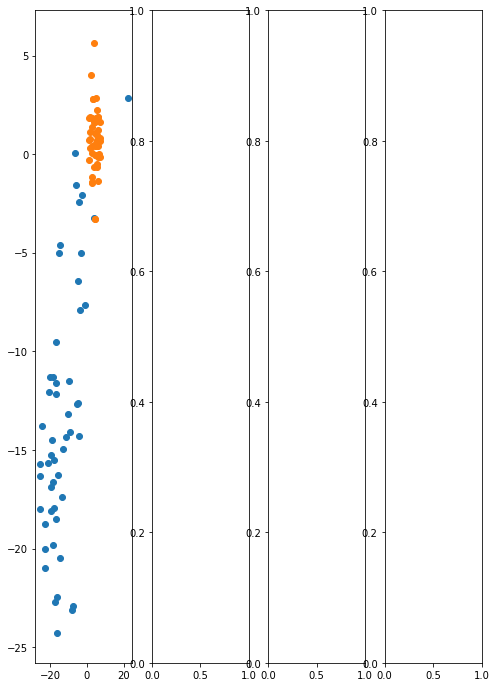

In [204]:
plotX = df_train.copy()

def build_sets(perplexity, plotX):
    tsne_1d = TSNE(n_components=1, perplexity=perplexity)
    tsne_2d = TSNE(n_components=2, perplexity=perplexity)
    tsne_3d = TSNE(n_components=3, perplexity=perplexity)

    TCs_1d = pd.DataFrame(tsne_1d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)
    TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)
    TCs_3d = pd.DataFrame(tsne_3d.fit_transform(plotX.drop(["cluster"], axis=1)), index=plotX.index)

    TCs_1d.columns = ["TC1_1d"]
    PCs_1d.columns = ["PC1_1d"]
    TCs_2d.columns = ["TC1_2d","TC2_2d"]
    TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]

    plotX = pd.concat([plotX,TCs_1d,TCs_2d,TCs_3d], axis=1, join='inner')
    plotX["dummy"] = 0

    cluster0 = plotX[plotX["cluster"] == 0]
    cluster1 = plotX[plotX["cluster"] == 1]
    cluster2 = plotX[plotX["cluster"] == 2]
    
    display(type(cluster0))
    return cluster0,cluster1,cluster2

init_notebook_mode(connected=True)

fig,ax = plt.subplots(1,4,figsize=(8, 12)) 

# for i in [10,20,30, 40,50,60, 70,80,90]:
for i in [10, 40]:
    c0,c1,c2 = build_sets(i,plotX)    

    display(c0.head(3))
    display(c1.head(3))
    ax[0].scatter(c0['TC1_2d'], c0['TC2_2d'])



## Need to figure out do I keep causes & deaths as indicators ?  Weigh them?  Add a cases/trending 3,7,14 day rolling avg?

# Pop Density vs Case counts

NameError: name 'df_gmerged2' is not defined

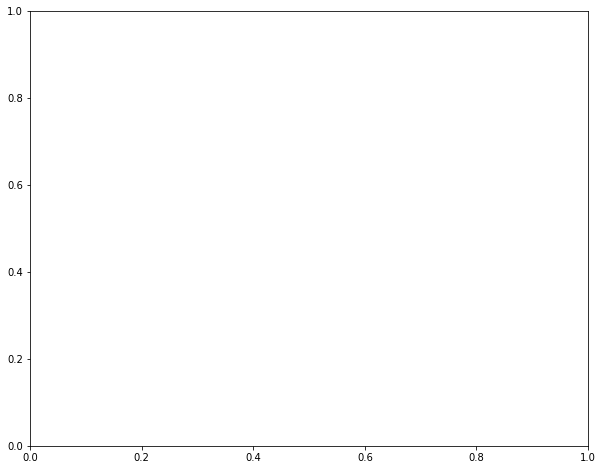

In [82]:
max_ctys = 30
fig,ax1 = plt.subplots(figsize=(10, 8)) 

df_gmerged_h = df_gmerged2[df_gmerged2['Cases'] > 1000].sort_values(by=['popdensity'],ascending=False).head(max_ctys)

ax1.set_xlabel('Cases')  
ax1.set_xscale('linear')
ax1.barh(df_gmerged_h['Country/Region'], df_gmerged_h['Cases'], color='xkcd:green')
for n,i in enumerate(ax1.patches):
    ax1.text(i.get_width()+.02, i.get_y()+.5,'density: '+str(df_gmerged_h['popdensity'].iloc[n:n+1].round(2).item()) + ', pop: '+str(df_gmerged_h['Population'].iloc[n:n+1].div(1000000).round(0).item()) +'M, '+str(df_gmerged_h['% of pop'].iloc[n:n+1].round(2).item())  +'%', color='xkcd:blue')

# ax2 = ax1.twiny()
# ax2.set_xscale('linear')
# ax2.set(xlim=[0, 10])   # get max min +/- buffer
# ax2.set_xlabel('Population density', color='xkcd:red')  
# ax2.spines['top'].set_color('red')
# ax2.tick_params(axis='x', colors='red')
# ax2.barh(df_gmerged_h['Country/Region'], df_gmerged_h['popdensity'], color='xkcd:red')
# for n,i in enumerate(ax2.patches):
#     ax2.text(i.get_width()+.02, i.get_y()+.5,str(df_gmerged_h['popdensity'].iloc[n:n+1].item()), color='xkcd:red')

plt.title('Top Population Density Countries > 1000 cases')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# read from JSON directly WIP -- would be more optimal than above but scrap for now
# EN.ATM.PM25.MC.M3 - polution
# able to aggrecate and get last value, not sure what source= is    ?source=2&format=json&mrnev=1&per_page=500
#   http://api.worldbank.org/v2/country/all/indicator/EN.ATM.PM25.MC.M3;SH.MED.BEDS.ZS;IS.AIR.DPRT;IS.RRS.TOTL.KM;SP.URB.TOTL.IN.ZS;SP.POP.TOTL;SL.UEM.TOTL.ZS?source=2&format=json&mrnev=1&per_page=5000
#jurl = 'http://api.worldbank.org/v2/country/all/indicator/EN.ATM.PM25.MC.M3;SH.MED.BEDS.ZS;IS.AIR.DPRT;IS.RRS.TOTL.KM;SP.URB.TOTL.IN.ZS;SP.POP.TOTL;SL.UEM.TOTL.ZS?source=2&format=json&mrnev=1&per_page=5000'
    
#r = requests.get(jurl)
#display(r.text)
#    
#pd.read_json(r.text)

